In [1]:
from __future__ import absolute_import, division, print_function

import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

keras = tf.keras

In [3]:
import tensorflow_datasets as tfds

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [10]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip", 
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

68608000/68606236 [==============================] - 11s 0us/step


In [11]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


In [12]:
image_size = 160 # All images will be resized to 160x160
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),  
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

9412608/9406464 [==============================] - 27s 3us/step


In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [18]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [20]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 14s 225ms/step - loss: 0.7111 - accuracy: 0.5650 - val_loss: 0.6120 - val_accuracy: 0.6351
Epoch 2/10
62/62 [==============================] - 8s 121ms/step - loss: 0.5737 - accuracy: 0.7154 - val_loss: 0.4564 - val_accuracy: 0.8226
Epoch 3/10
62/62 [==============================] - 7s 115ms/step - loss: 0.4765 - accuracy: 0.7891 - val_loss: 0.3566 - val_accuracy: 0.8790
Epoch 4/10
62/62 [==============================] - 7s 116ms/step - loss: 0.4053 - accuracy: 0.8379 - val_loss: 0.2970 - val_accuracy: 0.9002
Epoch 5/10
62/62 [==============================] - 7s 115ms/step - loss: 0.3482 - accuracy: 0.8765 - val_loss: 0.2569 - val_accuracy: 0.9093
Epoch 6/10
62/62 [==============================] - 8s 124ms/step - loss: 0.3236 - accuracy: 0.8872 - val_loss: 0.2340 - val_accuracy: 0.9183
Epoch 7/10
62/62 [==============================] - 7s 105ms/step - loss: 0.2963 - accuracy: 0.8923 - val_loss: 0.2140 - val_accuracy: 0.9304
Epoch

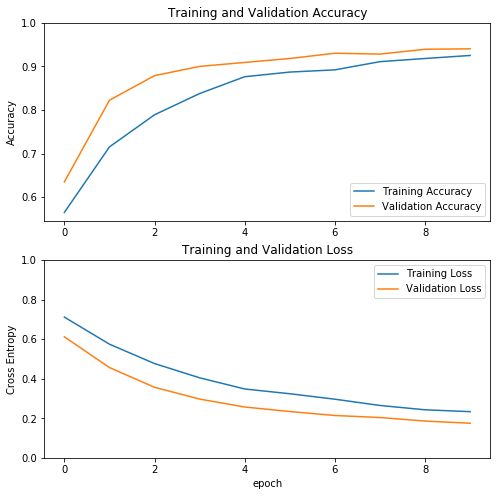

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [25]:

model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [27]:
len(model.trainable_variables)

58

In [28]:
history_fine = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 21s 345ms/step - loss: 0.1563 - accuracy: 0.9487 - val_loss: 0.0945 - val_accuracy: 0.9677
Epoch 2/10
62/62 [==============================] - 9s 145ms/step - loss: 0.1033 - accuracy: 0.9654 - val_loss: 0.0774 - val_accuracy: 0.9758
Epoch 3/10
62/62 [==============================] - 9s 142ms/step - loss: 0.0616 - accuracy: 0.9837 - val_loss: 0.0710 - val_accuracy: 0.9788
Epoch 4/10
62/62 [==============================] - 9s 150ms/step - loss: 0.0416 - accuracy: 0.9914 - val_loss: 0.0730 - val_accuracy: 0.9768
Epoch 5/10
62/62 [==============================] - 10s 159ms/step - loss: 0.0411 - accuracy: 0.9869 - val_loss: 0.0700 - val_accuracy: 0.9808
Epoch 6/10
62/62 [==============================] - 8s 133ms/step - loss: 0.0165 - accuracy: 0.9980 - val_loss: 0.0712 - val_accuracy: 0.9778
Epoch 7/10
62/62 [==============================] - 8s 133ms/step - loss: 0.0151 - accuracy: 0.9975 - val_loss: 0.0698 - val_accuracy: 0.9819
Epoc

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

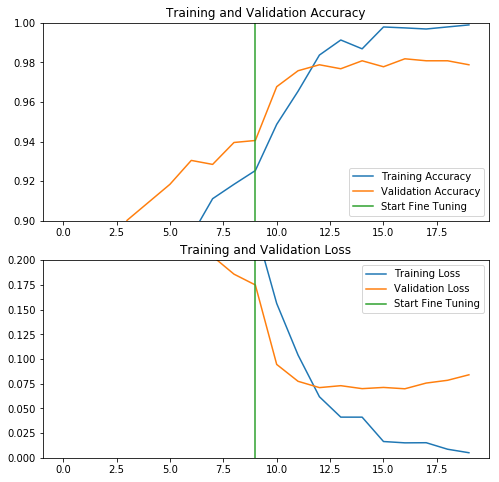

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()